# BI-LSTM Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense,Dropout,Flatten
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_Original.csv")
df.head()

,tweet_id,label,text,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,570306133677760513,2,@VirginAmerica What @dhepburn said.,35,what say,8,"['what', 'say']"
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,570301083672813571,2,@VirginAmerica I didn't today... Must mean I n...,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,570301031407624196,0,@VirginAmerica it's really aggressive to blast...,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,570300817074462722,0,@VirginAmerica and it's a really big bad thing...,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

tweet_id                  0
label                     0
text                      0
length                    0
preprocessed_abstract    17
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [5]:
sentences = [sentence.split() for sentence in df['preprocessed_abstract']]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[-3.6382791e-01,  5.1625359e-01,  6.3389406e-02, ...,
        -5.8102769e-01, -5.2543625e-02, -5.1870838e-02],
       [-9.5150614e-01,  9.3377626e-01, -2.0073819e-01, ...,
        -1.2662052e+00,  1.8780349e-01, -1.0854270e+00],
       [-2.7359626e-01,  6.1016399e-01, -1.6042434e-01, ...,
        -5.6109631e-01,  1.2056493e-02, -1.0329124e-01],
       ...,
       [ 6.3048396e-03,  9.9999653e-03, -1.3102209e-03, ...,
        -6.1097546e-03, -2.8172659e-03, -5.4935343e-03],
       [ 4.2020432e-03,  2.2922228e-03,  2.9572798e-03, ...,
        -1.2953891e-02,  8.2469266e-03, -1.3672604e-02],
       [-1.2044678e-02,  3.7951590e-03,  6.0951812e-03, ...,
        -1.9788742e-02,  5.1768438e-04, -1.4947181e-02]], dtype=float32)

In [6]:
word_vectors.vectors.shape

(9314, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (11698,) (11698,)
Test data: (2925,) (2925,)


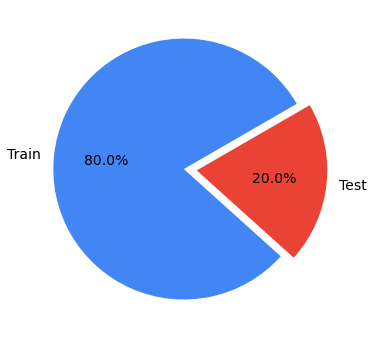

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[ 218   38 1064 ...    0    0    0]
 [ 360  225   99 ...    0    0    0]
 [   2  334  599 ...    0    0    0]
 ...
 [  53  278   11 ...    0    0    0]
 [ 218 1150  251 ...    0    0    0]
 [  84  199    2 ...    0    0    0]]


In [10]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[524  14  13 ...   0   0   0]
 [  1   3  17 ...   0   0   0]
 [ 34  33   4 ...   0   0   0]
 ...
 [ 85 241  44 ...   0   0   0]
 [481   8 850 ...   0   0   0]
 [  1  16   7 ...   0   0   0]]


##### 4)Model Architecture

In [11]:
model = Sequential()
model.add(Embedding(word_vectors.vectors.shape[0],100, input_length=max_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           931400    
                                                                 
 dropout (Dropout)           (None, 26, 100)           0         
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 1166667 (4.45 MB)
Trainable params: 1166667 (4.45 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

##### 5) Training Model

In [14]:
history=model.fit(padded_docs_train, y_train, epochs=5, batch_size=64, validation_data=(padded_docs_test, y_test))
history

Epoch 1/5


183/183 [==============================] - 10s 36ms/step - loss: 0.7428 - accuracy: 0.6900 - val_loss: 0.9090 - val_accuracy: 0.6263
Epoch 2/5
183/183 [==============================] - 6s 32ms/step - loss: 0.4990 - accuracy: 0.8065 - val_loss: 1.1170 - val_accuracy: 0.6239
Epoch 3/5
183/183 [==============================] - 6s 31ms/step - loss: 0.4022 - accuracy: 0.8460 - val_loss: 1.1708 - val_accuracy: 0.6137
Epoch 4/5
183/183 [==============================] - 6s 32ms/step - loss: 0.3442 - accuracy: 0.8722 - val_loss: 1.4224 - val_accuracy: 0.5703
Epoch 5/5
183/183 [==============================] - 6s 33ms/step - loss: 0.2984 - accuracy: 0.8859 - val_loss: 1.5111 - val_accuracy: 0.5979


##### 6) Finding Training and Testing Accuracy

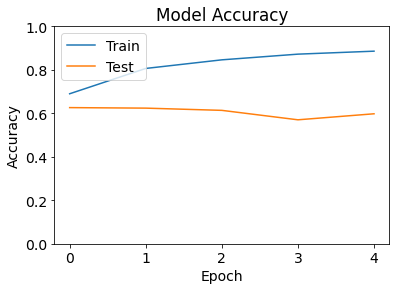

In [15]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
test_loss,test_acc=model.evaluate(padded_docs_test,y_test)
test_loss,test_acc

92/92 [==============================] - 1s 12ms/step - loss: 1.5111 - accuracy: 0.5979


(1.5111078023910522, 0.5979487299919128)

##### 7) Compute and plot the confusion matrix for the three classes

In [17]:
predictions=model.predict(padded_docs_test)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

92/92 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

    negative       0.67      0.82      0.74      1835
     neutral       0.33      0.22      0.27       617
    positive       0.41      0.23      0.29       473

    accuracy                           0.60      2925
   macro avg       0.47      0.42      0.43      2925
weighted avg       0.56      0.60      0.57      2925



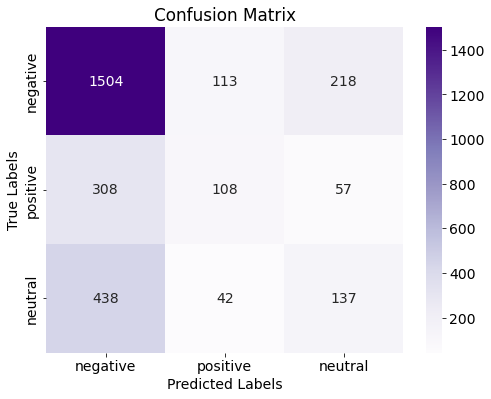

In [18]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [19]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.66844444 0.33252427 0.41064639]
Recall per class: [0.81961853 0.22204214 0.22832981]


In [20]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.597948717948718
Macro F1 Score: 0.4320362365989397


In [21]:
data={'Original_Dataset':[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]}
result=pd.DataFrame(data,index=['Training Accuracy','Testing Accuracy','Micro F1 Score','Macro F1 Score','Precision for Negative sentiment','Precision for Positive sentiment','Precision for Neutral sentiment','Recall for Negative sentiment','Recall for Positive sentiment','Recall for Neutral sentiment'])
result

,Original_Dataset
Training Accuracy,0.885878
Testing Accuracy,0.597949
Micro F1 Score,0.597949
Macro F1 Score,0.432036
Precision for Negative sentiment,0.668444
Precision for Positive sentiment,0.332524
Precision for Neutral sentiment,0.410646
Recall for Negative sentiment,0.819619
Recall for Positive sentiment,0.222042
Recall for Neutral sentiment,0.228330


In [22]:
result.to_csv('BILSTMModelResults.csv', index=True)